In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import sys
import math
from hft_rsys import *
import matplotlib.pyplot as plt
import copy
from Helper import *
from observe_order_book import HRB
import seaborn as sns
# Caveat
import importlib
import pickle
from Microstructure_Factors import *
import IPython
# ML Libs
from sklearn import tree
%load_ext autoreload

hft research system version 2.2


In [2]:
%%capture
st = dt.datetime(2019, 7, 17)
et = dt.datetime(2019, 7, 31)
contract = "IF"
month = "1908"
source = "l2_cffex"
hrb = HRB.HRB(st, et, contract, month, source, 0);

print("Loading original data")

Build Microstructure Factos Now

In [3]:
%aimport Microstructure_Factors
%autoreload 1

msf = MSF_Library(hrb)
# self.df["bid_or_ask"], self.response_list
msf.generate_signal()
msf.condition = "ba"
msf.period = 10
pd.set_option('display.max_columns', 500)


Initializing MSF_Library
Signal points: 1055


In [4]:
print("Loading the factors......")
#get_vwap_value(msf.df, msf.multiplier, msf.vol_side, msf.condition)
#get_vwap_position(msf.df, msf.multiplier, msf.vol_side, msf.condition)
get_ret_direction(msf.df, msf.min_tick, msf.period, msf.condition, "tick")
#get_ret_direction(msf.df, msf.min_tick, -1, msf.condition, "tick")
# more ret_direction should be added
#get_sprd_ma(msf.df, msf.min_tick, msf.period)
#get_sprd_stdev(msf.df, msf.min_tick, msf.period)
#get_volume_frac(msf.df, msf.period)

#get_lv1_distance(msf.df, msf.min_tick, msf.condition, -1)
#get_widen_distance(msf.df, msf.min_tick, msf.condition, True)
#get_best_quote_ratio(msf.df, msf.condition)

#get_TT_mean(msf.df, msf.multiplier, msf.vol_side, msf.period, msf.condition)
#get_SN_mean(msf.df, msf.period, msf.condition)
#get_TR_mean(msf.df, msf.multiplier, msf.vol_side, msf.period, msf.condition)

get_price_stdev(msf.df, msf.min_tick, msf.period, msf.condition)
msf.df["sprd"] = ((msf.df["AskPrice1"] - msf.df["BidPrice1"])/msf.min_tick).round()
# log volume
#msf.df["volume"] = np.log(msf.df["volume"] + 1)
print(msf.df.columns)

Loading the factors......
Index(['BidPrice5', 'BidSize5', 'BidPrice4', 'BidSize4', 'BidPrice3',
       'BidSize3', 'BidPrice2', 'BidSize2', 'BidPrice1', 'BidSize1',
       'AskPrice1', 'AskSize1', 'AskPrice2', 'AskSize2', 'AskPrice3',
       'AskSize3', 'AskPrice4', 'AskSize4', 'AskPrice5', 'AskSize5',
       'TimeStamp', 'hCount', 'volume', 'turnover', 'FallLimit', 'RiseLimit',
       'TotalVolume', 'Turnover', 'MidPrice', 'vwap', 'bid_or_ask', 'ret_10',
       'base_price_stdev', 'oppo_price_stdev', 'sprd'],
      dtype='object')


Preparing the features....


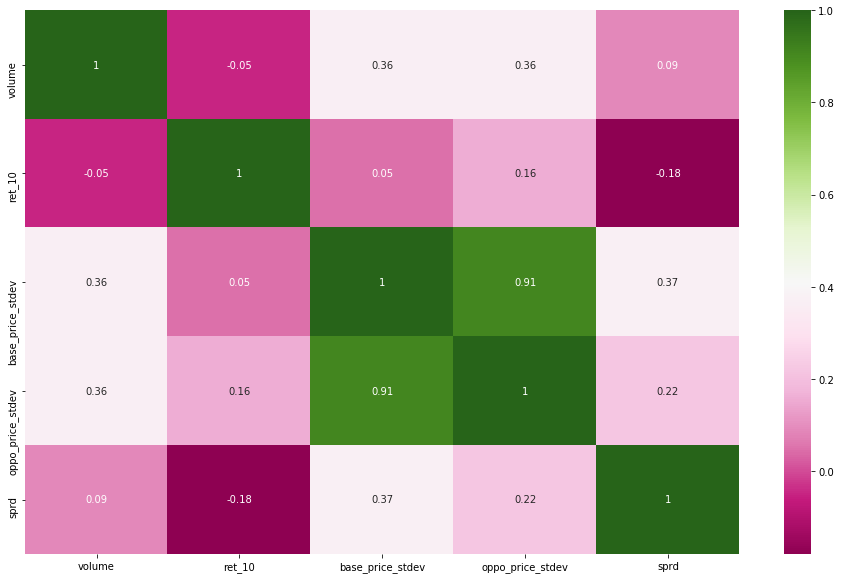

In [10]:

print("Preparing the features....")
unused_column_names = ["BidPrice5", "BidSize5", "BidPrice4", "BidSize4",
                        "BidPrice3", "BidSize3", "BidPrice2", "BidSize2",
                        "BidPrice1", "BidSize1", "AskPrice1", "AskSize1",
                        "AskPrice2", "AskSize2", "AskPrice3", "AskSize3",
                        "AskPrice4", "AskSize4", "AskPrice5", "AskSize5",
                        "TimeStamp", "FallLimit", "RiseLimit", "hCount",
                        "TotalVolume", "Turnover", "MidPrice", "vwap", 
                        "bid_or_ask", "turnover"]

tdf = copy.deepcopy(msf.df)
# remove first 50 rows
tdf = tdf.iloc[50:]
# leave only rows with signals
tdf = tdf[tdf["bid_or_ask"] != "NAN"]
tdf.drop(unused_column_names, axis = 1, inplace = True)
#print(tdf.columns)
corr = tdf.corr().round(2)
%matplotlib inline 
fig = plt.figure(figsize=(16, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot = True, cmap="PiYG")


In [11]:

print("Prepare the responses....")
feature_names = tdf.columns.values
predictors = tdf.values
responses = msf.response_list[50:]
responses = responses[~np.isnan(responses)]

"""
for name in feature_names:
    print(name + ":")
    print(tdf[name].isnull().any().any())
print(len(responses))
print(predictors.shape)
"""
print(len(responses))


Prepare the responses....
1055


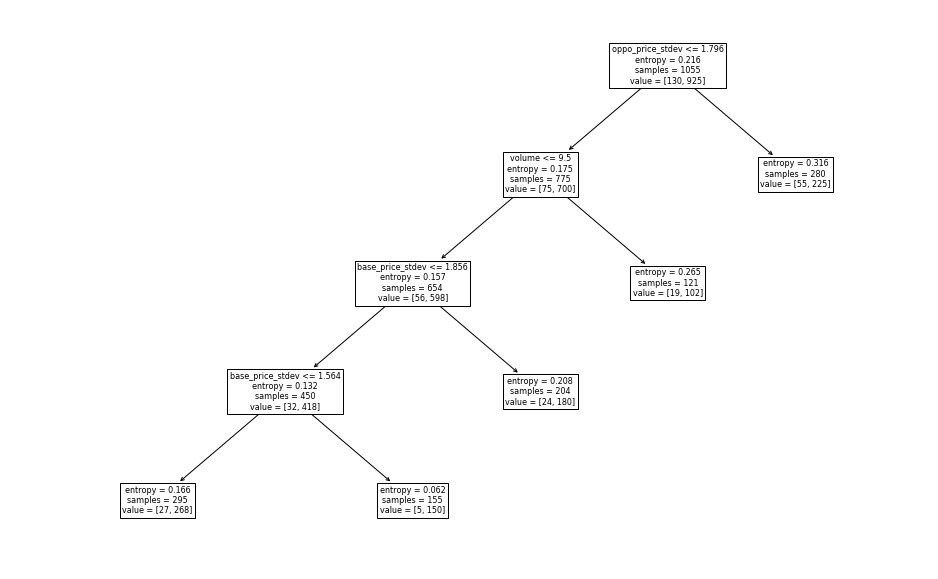

In [12]:
clf = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split = 300, 
                                  min_samples_leaf = 100) #, class_weight = "balanced"
clf = clf.fit(predictors, responses)

%matplotlib qt
#%matplotlib inline 
fig = plt.figure(figsize=(16, 10))
tree.plot_tree(clf, feature_names = feature_names, fontsize = 8)
plt.show()

Feature importance


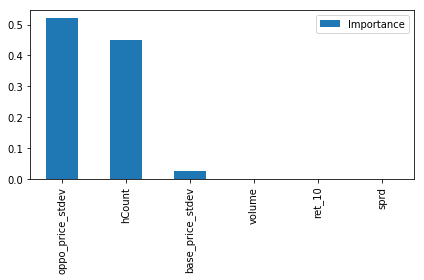

In [8]:
plt.close()
%matplotlib inline 

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=feature_names, 
                          columns=["Importance"])
importance.sort_values(by = ["Importance"], ascending = False, inplace = True)
importance.plot.bar()
print("Feature importance")
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()